# ARIMAモデル

- とりあえず、ある店舗についてARIMAモデルを適用してみる

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tsa.arima_model import AR, ARMA, ARIMA
from IPython.display import  display
sns.set_style('whitegrid')
%matplotlib inline

## データの取得

In [2]:
features_format = pd.read_csv('../data/features_format.csv', engine='python')

In [3]:
features_format['visit_date'] = pd.to_datetime(features_format['visit_date'])
features_format.dtypes

air_store_id            object
visit_date      datetime64[ns]
visitors               float64
dtype: object

In [4]:
# 期間中に欠損のない店舗を見つける
# だが、そんな店舗はなかった
is_open_everyday = features_format.groupby('air_store_id').apply(lambda x : x.isnull().any(axis=0).visitors)
is_open_everyday[is_open_everyday ==  False]

Series([], dtype: bool)

In [5]:
# 期間中に最もレコードの多い店舗は？
num_of_opne_day = features_format.groupby('air_store_id').apply(lambda x : x.count().visitors)
num_of_opne_day.sort_values(ascending=False).head()

air_store_id
air_5c817ef28f236bdf    438
air_a083834e7ffe187e    438
air_36bcf77d3382d36e    437
air_d97dabf7aae60da5    437
air_232dcee6f7c51d37    436
dtype: int64

## "air_5c817ef28f236bdf"というお店の来客予測を行う
air_5c817ef28f236bdf は渋谷にある居酒屋らしい

In [6]:
train_data = features_format.query('air_store_id == "air_5c817ef28f236bdf"')[['visit_date', 'visitors']]
# NAが1レコードあるため削除
train_data = train_data.dropna()
train_data = train_data.sort_values(by='visit_date').reset_index(drop=True)

In [7]:
train_data.shape

(438, 2)

In [8]:
train_data.head()

,visit_date,visitors
0,2016-01-02,24.0
1,2016-01-03,49.0
2,2016-01-04,10.0
3,2016-01-05,2.0
4,2016-01-06,9.0


## テストデータも用意

In [9]:
raw_test_data = pd.read_csv('../data/test_data.csv', engine='python')

In [10]:
raw_test_data.head()

,air_store_id,visit_date,id,visitors
0,air_00a91d42b08b08d9,2017-03-15,air_00a91d42b08b08d9_2017-03-15,42.0
1,air_00a91d42b08b08d9,2017-03-16,air_00a91d42b08b08d9_2017-03-16,39.0
2,air_00a91d42b08b08d9,2017-03-17,air_00a91d42b08b08d9_2017-03-17,37.0
3,air_00a91d42b08b08d9,2017-03-18,air_00a91d42b08b08d9_2017-03-18,4.0
4,air_00a91d42b08b08d9,2017-03-19,air_00a91d42b08b08d9_2017-03-19,NaN


In [11]:
test_data = raw_test_data.query('air_store_id == "air_5c817ef28f236bdf"')[['visit_date', 'visitors']]
test_data = test_data.sort_values(by='visit_date').reset_index(drop=True)

In [12]:
test_data.shape

(39, 2)

In [13]:
test_data.head()

,visit_date,visitors
0,2017-03-15,12.0
1,2017-03-16,30.0
2,2017-03-17,54.0
3,2017-03-18,71.0
4,2017-03-19,88.0


## データの可視化
## ※目盛りの値をどうにかしたい

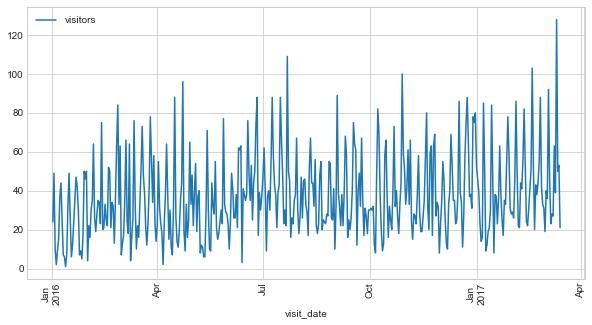

In [14]:
ax = train_data.plot(x='visit_date', y='visitors', figsize=(10,5), rot = 90)


### 差分とかをとる関数

In [15]:
def concat_diffs(data, key_column='visitors'):
    # 差分
    visitors_diff = data['visitors'].diff()
    visitors_diff.name = key_column + '_diff'

    # 変化率
    visitors_pct_change = data['visitors'].pct_change()
    visitors_pct_change.name = key_column + '_pct_change'

    # 対数差分
    visitors_log_diff = np.log(data['visitors']) - np.log(data['visitors'].shift(1))
    visitors_log_diff.name = key_column + '_log_diff'

    # まとめてreturn
    return pd.concat([data, visitors_diff, visitors_pct_change, visitors_log_diff], axis=1)
    


In [16]:
train_data_diffs = concat_diffs(train_data)
train_data_diffs.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
0,2016-01-02,24.0,NaN,NaN,NaN
1,2016-01-03,49.0,25.0,1.041667,0.713766
2,2016-01-04,10.0,-39.0,-0.795918,-1.589235
3,2016-01-05,2.0,-8.0,-0.800000,-1.609438
4,2016-01-06,9.0,7.0,3.500000,1.504077


In [17]:
train_data_diffs_dropna = train_data_diffs.dropna(axis=0)
train_data_diffs_dropna.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
1,2016-01-03,49.0,25.0,1.041667,0.713766
2,2016-01-04,10.0,-39.0,-0.795918,-1.589235
3,2016-01-05,2.0,-8.0,-0.800000,-1.609438
4,2016-01-06,9.0,7.0,3.500000,1.504077
5,2016-01-07,15.0,6.0,0.666667,0.510826


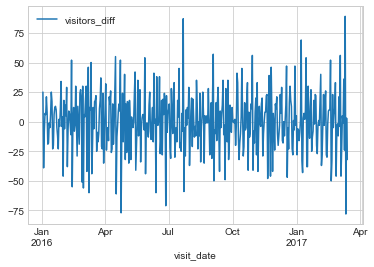

In [18]:
# 差分
train_data_diffs.plot(x='visit_date', y='visitors_diff')

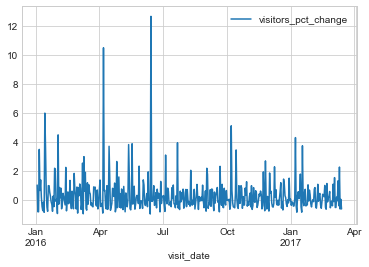

In [19]:
# 変化率
train_data_diffs.plot(x='visit_date', y='visitors_pct_change')

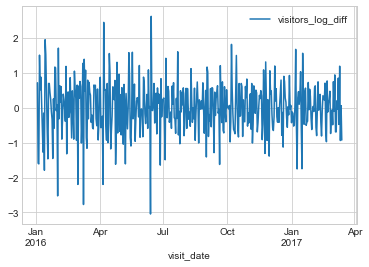

In [20]:
# 対数差分
train_data_diffs.plot(x='visit_date', y='visitors_log_diff')

## 自己相関のコレログラム

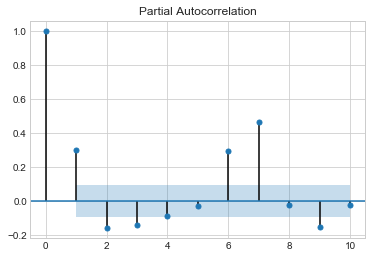

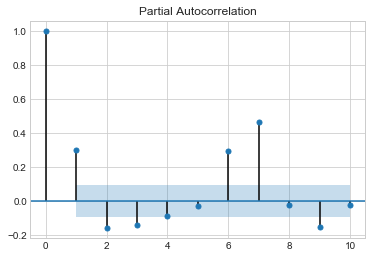

In [21]:
sm.graphics.tsa.plot_pacf(train_data_diffs['visitors'], lags=10)

In [22]:
sm.graphics.tsa.plot_acf

<function statsmodels.graphics.tsaplots.plot_acf(x, ax=None, lags=None, alpha=0.05, use_vlines=True, unbiased=False, fft=False, title='Autocorrelation', zero=True, vlines_kwargs=None, **kwargs)>

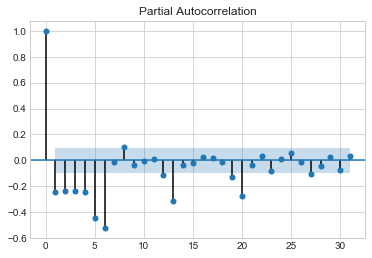

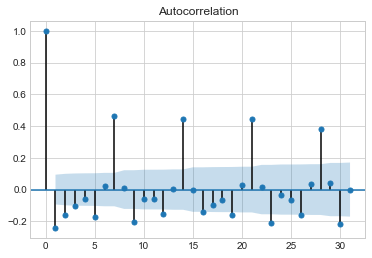

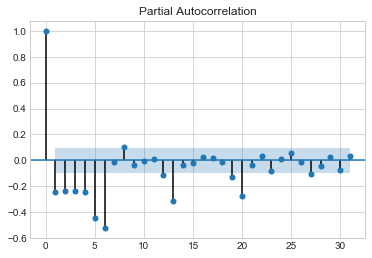

In [23]:
sm.graphics.tsa.plot_acf(train_data_diffs_dropna['visitors_diff'], lags=31)
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_diff'], lags=31)

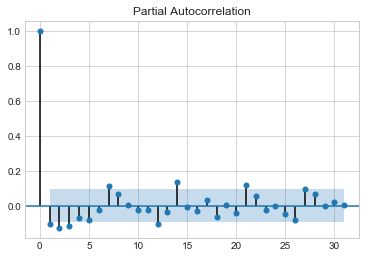

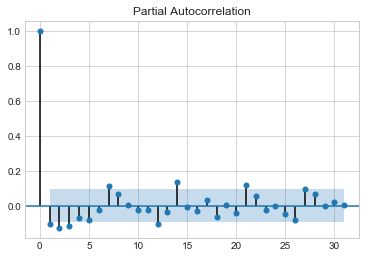

In [24]:
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_pct_change'], lags=31)

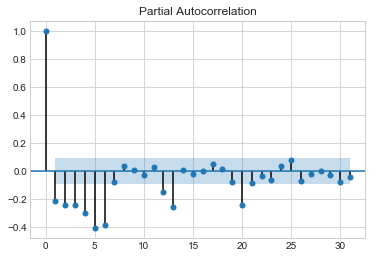

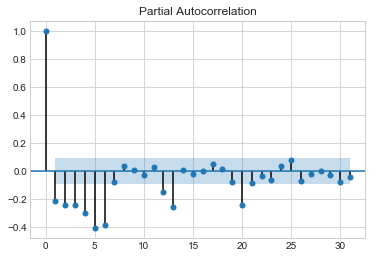

In [25]:
sm.graphics.tsa.plot_pacf(train_data_diffs_dropna['visitors_log_diff'], lags=31)

# 予測

In [26]:
result = ARIMA(train_data_diffs_dropna['visitors_diff'].values, order=(7,2,2), dates=train_data_diffs_dropna['visit_date']).fit()

C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\hiroshi_kuriyama\AppData\Local\conda\conda\envs\recruit_py36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


In [27]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                   D2.y   No. Observations:                  435
Model:                 ARIMA(7, 2, 2)   Log Likelihood               -1860.794
Method:                       css-mle   S.D. of innovations             16.840
Date:                Fri, 22 Jun 2018   AIC                           3743.589
Time:                        17:10:40   BIC                           3788.417
Sample:                    01-05-2016   HQIC                          3761.282
                         - 03-14-2017                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.39e-05   2.18e-05      0.637      0.524   -2.89e-05    5.67e-05
ar.L1.D2.y    -0.7826      0.048    -16.236      0.000      -0.877      -0.688
ar.L2.D2.y    -0.7843      0.055    -14.180      0.000      -0.893      -0.676
ar.L3.D2.y    -0.7851      0.057    -13.871      0.000      -0.896      -0.674
ar.L4.D2.y    -0.7310      0.058    -12.531      0.000      -0.845      -0.617
ar.L5.D2.y    -0.7350      0.057    -12.885      0.000      -0.847      -0.623
ar.L6.D2.y    -0.5569      0.056    -10.032      0.000      -0.666      -0.448
ar.L7.D2.y    -0.0265      0.049     -0.538      0.591      -0.123       0.070
ma.L1.D2.y    -1.9961      0.001  -1369.494      0.000      -1.999      -1.993
ma.L2.D2.y     0.9961      0.001    679.281      0.000       0.993       0.999
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.6538           -0.8205j            1.0491           -0.1429
AR.2            0.6538           +0.8205j            1.0491            0.1429
AR.3           -0.2414           -1.0814j            1.1080           -0.2850
AR.4           -0.2414           +1.0814j            1.1080            0.2850
AR.5           -1.0835           -0.4955j            1.1914           -0.4317
AR.6           -1.0835           +0.4955j            1.1914            0.4317
AR.7          -19.6707           -0.0000j           19.6707           -0.5000
MA.1            1.0019           -0.0021j            1.0019           -0.0003
MA.2            1.0019           +0.0021j            1.0019            0.0003
-----------------------------------------------------------------------------
"""

In [28]:
predict = result.predict(start='2017-03-15', end='2017-04-22')

### テストデータの差分も作成

In [29]:
test_data_diffs = concat_diffs(test_data)
test_data_diffs.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
0,2017-03-15,12.0,NaN,NaN,NaN
1,2017-03-16,30.0,18.0,1.500000,0.916291
2,2017-03-17,54.0,24.0,0.800000,0.587787
3,2017-03-18,71.0,17.0,0.314815,0.273696
4,2017-03-19,88.0,17.0,0.239437,0.214657


In [30]:
test_data_diffs_dropna = test_data_diffs.dropna(axis=0)
test_data_diffs_dropna.head()

,visit_date,visitors,visitors_diff,visitors_pct_change,visitors_log_diff
1,2017-03-16,30.0,18.0,1.500000,0.916291
2,2017-03-17,54.0,24.0,0.800000,0.587787
3,2017-03-18,71.0,17.0,0.314815,0.273696
4,2017-03-19,88.0,17.0,0.239437,0.214657
5,2017-03-20,35.0,-53.0,-0.602273,-0.921989


Text(0,0.5,'Visitors')

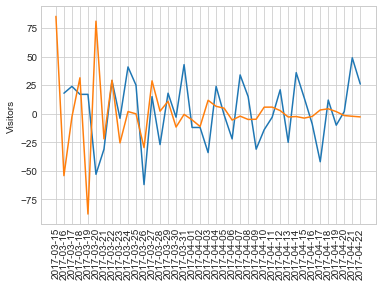

In [47]:
ax = plt.subplot()
ax.plot(test_data_diffs['visit_date'], test_data_diffs['visitors_diff'], label='Actual')
ax.plot(test_data_diffs['visit_date'], predict, label='Predict')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Visitors')

### 訓練データも含めたプロットを作る

In [36]:
# 3月の訓練データも含める
train_data_partial = train_data.query('visit_date >= "2017-03-01"')
test_data_large = pd.concat([train_data_partial, test_data]).reset_index()
test_data_large_diffs = concat_diffs(test_data_large)

In [45]:
predict_large = result.predict(start='2017-03-01', end='2017-04-22', dynamic=True)

Text(0,0.5,'Visitors')

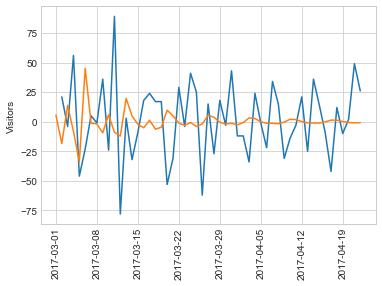

In [46]:
ax = plt.subplot()
ax.plot(test_data_large_diffs['visit_date'], test_data_large_diffs['visitors_diff'], label='Actual')
ax.plot(test_data_large_diffs['visit_date'], predict_large, label='Predict')
ax.tick_params(axis='x', rotation=90)
ax.set_ylabel('Visitors')